In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
#hep.CMS.text("Phase 2 Simulation")


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

# #line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

#####----------------------------------------------------------------

model_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'


def score_transform_old(iso, pt):
    
    PFTAU_NN_OFFSET = 0.1
    PFTAU_NN_SLOPE = 0.2
    PFTAU_NN_OVERALL_SCALE = 1. / 20.1

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 100.0
    
    return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))*PFTAU_NN_OVERALL_SCALE


def score_transform_new(iso, pt):
    
    PFTAU_NN_OFFSET = 0.36865313
    PFTAU_NN_SLOPE = 0.00137913
    PFTAU_NN_OVERALL_SCALE = 1./3.

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 200.0
    
    return iso*PFTAU_NN_OVERALL_SCALE*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))

2023-03-28 13:06:50.656193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 13:06:51.804934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/submit/dhoang/DQ/core-inst/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib64:/e906/app/software/osg/software/e1039/share-20210115/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib64:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/root/lib
2023-03-28 13:

In [10]:
truth_sig_pt_cut = 20.

#Filter out the test signals
sig = uproot4.open("../../ntuples/Jan_25_2023/test_sig_v11.root")
bkg = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v11.root")

#Calculate the fake rate for old nn
unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array())[400000:])
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array())[400000:])

#Sig
truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[400000:]
truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:]
truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]

iso_sig = sig['ntuplePupSingle']['tree']['chargedIso'].array()[400000:]

selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) & (abs(truth_eta_sig) < 2.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[400000:][selection_sig])
reco_sig_pt_selected = np.asarray(reco_pt_sig[selection_sig])
sig_iso_selected = np.asarray(iso_sig[selection_sig])
y_sig = score_transform_old(sig_iso_selected, reco_sig_pt_selected)

#Bkg
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()[400000:])
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()[400000:]) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]
bkg_pt_selected = bkg_pt[selection_bkg]
bkg_iso_selected = np.asarray(bkg['ntuplePupSingle']['tree']['chargedIso'].array()[400000:])[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

y_bkg = score_transform_old(bkg_iso_selected, bkg_pt_selected)

In [11]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])
    
    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

In [12]:
bkg_list_scaled = [i*(32e+3) for i in bkg_list]

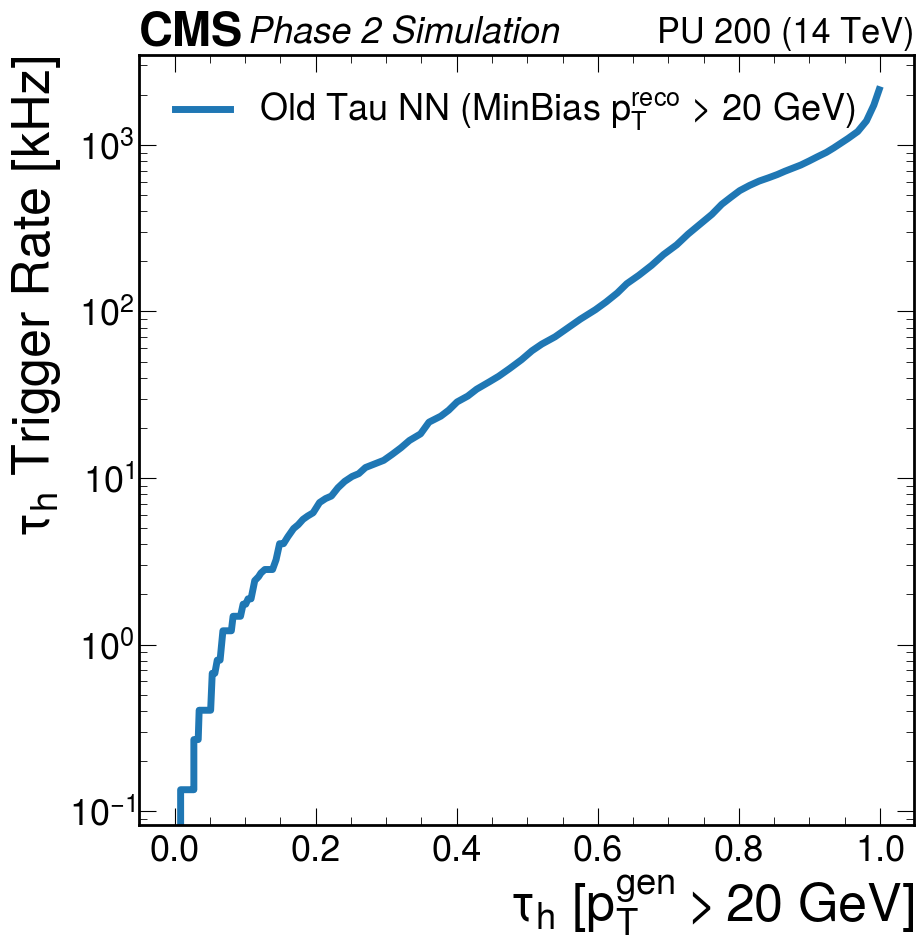

In [13]:
# sig_list_normal = np.load('sig_list_v3.npy')
# bkg_list_normal = np.load('bkg_list_v3.npy')
# bkg_list_normal_scaled = [i*(32e+3) for i in bkg_list_normal]

# plt.plot(sig_list_normal, bkg_list_normal_scaled, label='Retrained Tau NN',linewidth=5)
plt.plot(sig_list, bkg_list_scaled, label=r'Old Tau NN (MinBias $p_T^{reco}$ > 20 GeV)',linewidth=5)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > %d$ GeV]'%int(truth_sig_pt_cut))
plt.yscale('log')
plt.legend()

In [14]:
np.save('Feb_4_2023_OldNN_x_pT{}.npy'.format(int(truth_sig_pt_cut)), np.asarray(sig_list))
np.save('Feb_4_2023_OldNN_y_pT{}.npy'.format(int(truth_sig_pt_cut)), np.asarray(bkg_list_scaled))

In [16]:
truth_sig_pt_cut = 20.

#Filter out the test signals
sig = uproot4.open("../../ntuples/Jan_25_2023/test_sig_v11.root")
bkg = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v11.root")

unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array())[400000:])

#Load model and select out the tau
model = load_model(model_name)

#Sig
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[400000:]

truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[400000:]
truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:]
truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]
selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[400000:][selection_sig])

X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
X_sig[abs(X_sig) > 1e+4] = 0.
y_sig = model.predict(X_sig)
#y_sig = score_transform_new(y_sig_model.flatten(), np.asarray(reco_pt_sig[selection_sig]).flatten())

#Bkg
bkg_input = np.asarray(bkg['ntuplePupSingle']['tree']['m_inputs'].array()[400000:])
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()[400000:])
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()[400000:]) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

bkg_input[abs(bkg_input) > 1e+4] = 0.
y_bkg = model.predict(bkg_input[selection_bkg])
#y_bkg = score_transform_new(y_bkg_model.flatten(), bkg_pt[selection_bkg].flatten())

573/573 [==============================] - 1s 1ms/step


In [17]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])
    
    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

bkg_list_scaled = [i*(32e+3) for i in bkg_list]

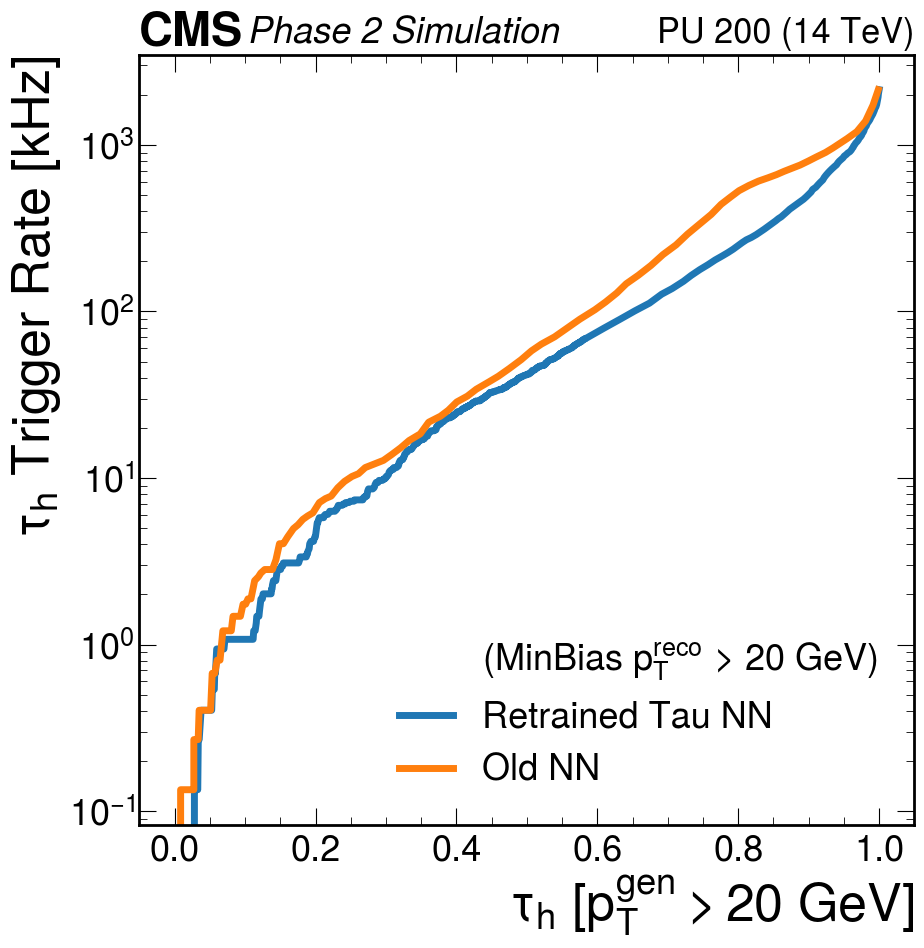

In [18]:
sig_list_old = np.load('Feb_4_2023_OldNN_x_pT{}.npy'.format(int(truth_sig_pt_cut)))
bkg_list_old = np.load('Feb_4_2023_OldNN_y_pT{}.npy'.format(int(truth_sig_pt_cut)))

plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco}$ > 20 GeV)')
plt.plot(sig_list, bkg_list_scaled, label=r'Retrained Tau NN',linewidth=5)
plt.plot(sig_list_old, bkg_list_old, label='Old NN',linewidth=5)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")

plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

plt.yscale('log')
plt.legend()

1023.8989803157706
Tau eff: 0.0700453234445818
Corresponding Tau Cut: 0.9923


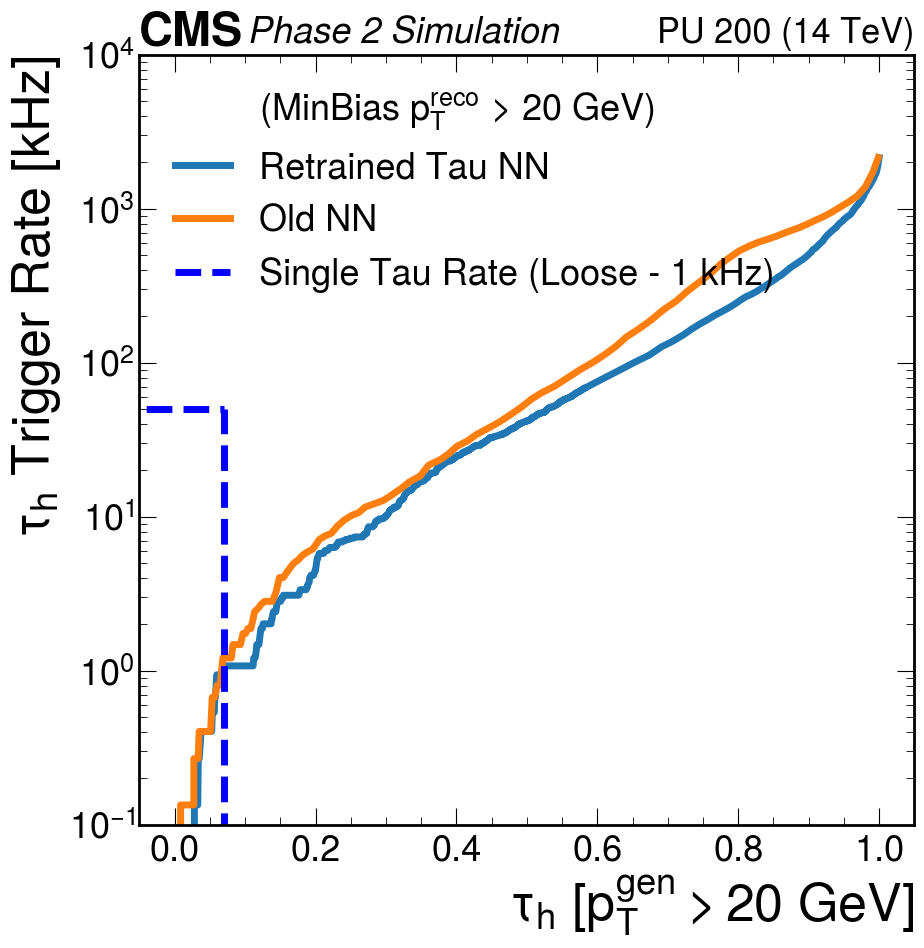

In [50]:
def find_nearest_indx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

tau_loose_cut_indx = find_nearest_indx(tau_score_edges, 0.05)
print(bkg_list_old[tau_loose_cut_indx])

#Find the working point
target_rate_loose = 1 #kHz
tau_eff = sig_list[find_nearest_indx(bkg_list_scaled, target_rate_loose)]
tau_cut = tau_score_edges[find_nearest_indx(bkg_list_scaled, target_rate_loose)]

print("Tau eff: {}".format(tau_eff))
print("Corresponding Tau Cut: {}".format(tau_cut))


sig_list_old = np.load('Feb_4_2023_OldNN_x_pT{}.npy'.format(int(truth_sig_pt_cut)))
bkg_list_old = np.load('Feb_4_2023_OldNN_y_pT{}.npy'.format(int(truth_sig_pt_cut)))


plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco}$ > 20 GeV)')
plt.plot(sig_list, bkg_list_scaled, label=r'Retrained Tau NN',linewidth=5)
plt.plot(sig_list_old, bkg_list_old, label='Old NN',linewidth=5)

#Plot the target rate
plt.hlines(target_rate,-1,tau_eff, color='b', linestyle='--', linewidth=5,
            label = r"Single Tau Rate (Loose - {} kHz)".format(target_rate_loose))
plt.vlines(tau_eff,0,target_rate, color='b', linestyle='--', linewidth=5)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")

plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

plt.xlim([-0.05,1.05])
plt.ylim([1e-1,1e+4])
plt.yscale('log')
plt.legend()

----

## Effciency at the tau cut

In [46]:
def plot_pt_eff_puppi(ModelName, DataPath, TreeName='ntuplePupSingle', cut_point = 0.05, test_indx=400000):
    
    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model = load_model(ModelName)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>1.) # " abs(gendr1) < 0.4 && pt > 1."

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]
    reco_tau_pt_select = reco_tau_pt[selection_num]
    
    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model.predict(np.nan_to_num(X_sig))
    
    nn_cut = y_sig.flatten() > cut_point
    
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Old nn
    old_tau_select = np.asarray(sig[TreeName]['tree']['passLoose'].array()[test_indx:][selection_num])
    tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)
    hist_selected_old_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)
    hist_selected_old_tau.fill(tau_pt_old_nn)
    
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (Old NN)",
        rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    
    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = eff_new_nn_artists.bar.datavalues

    eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
    eff_old_nn_err = eff_old_nn_artists.bar.datavalues
    
    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err = eff_puppi_artists.bar.datavalues

    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
    plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (PassLoose)')
    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err, fmt='o', label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"Efficiency")
    plt.legend(loc = 'center right')
    plt.show()

1545/1545 [==============================] - 2s 965us/step


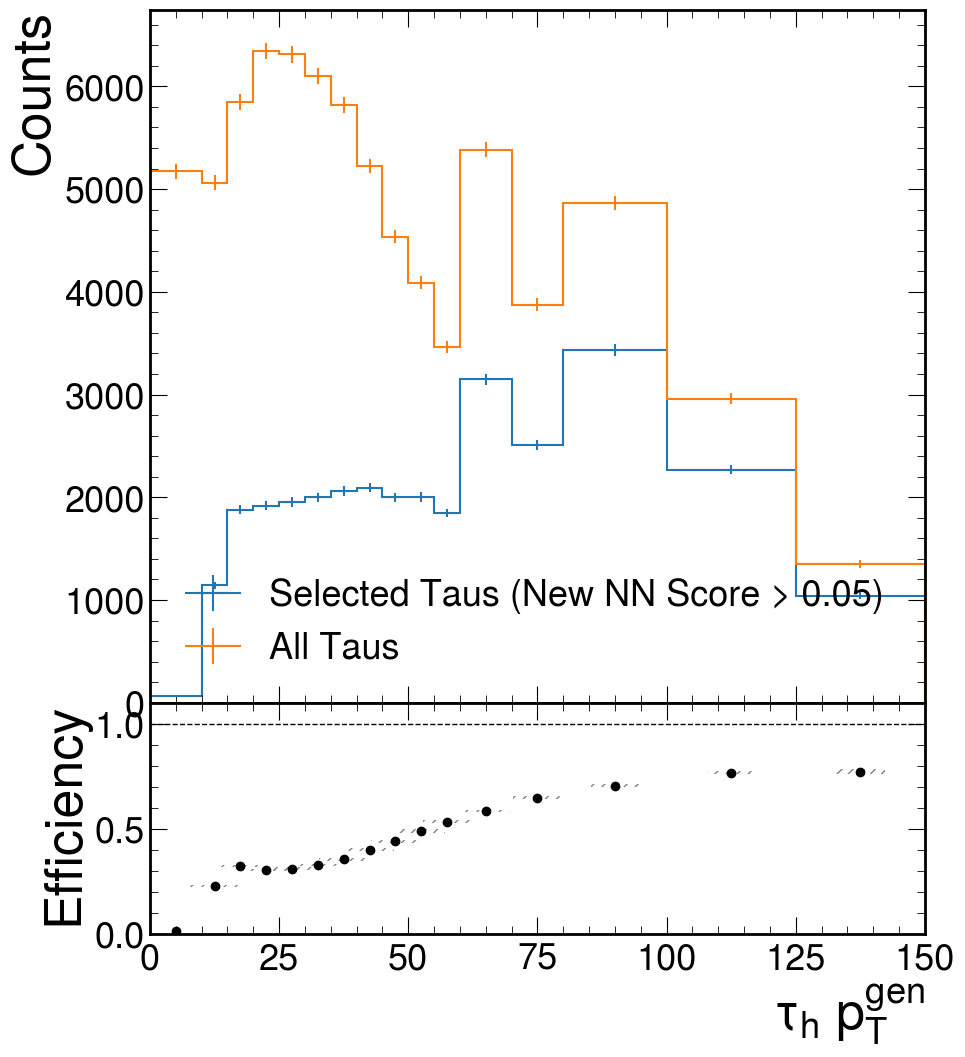

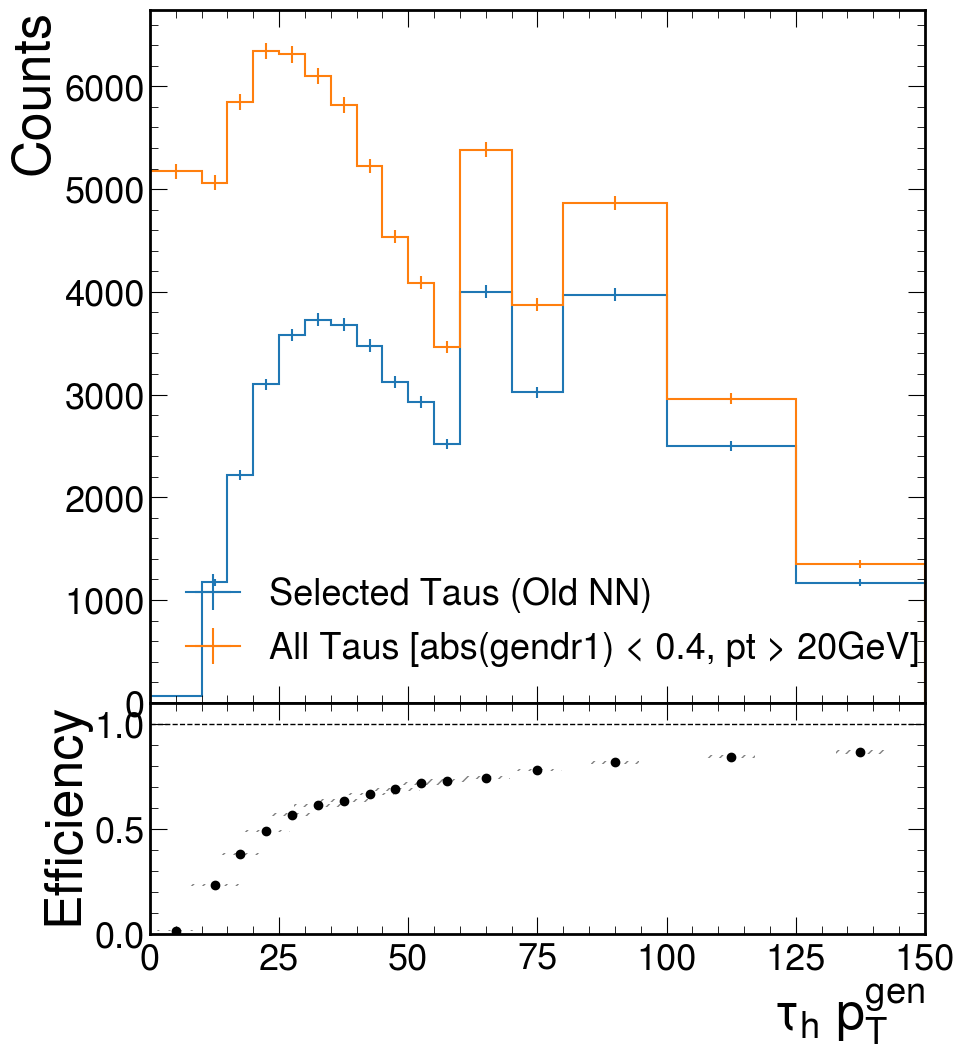

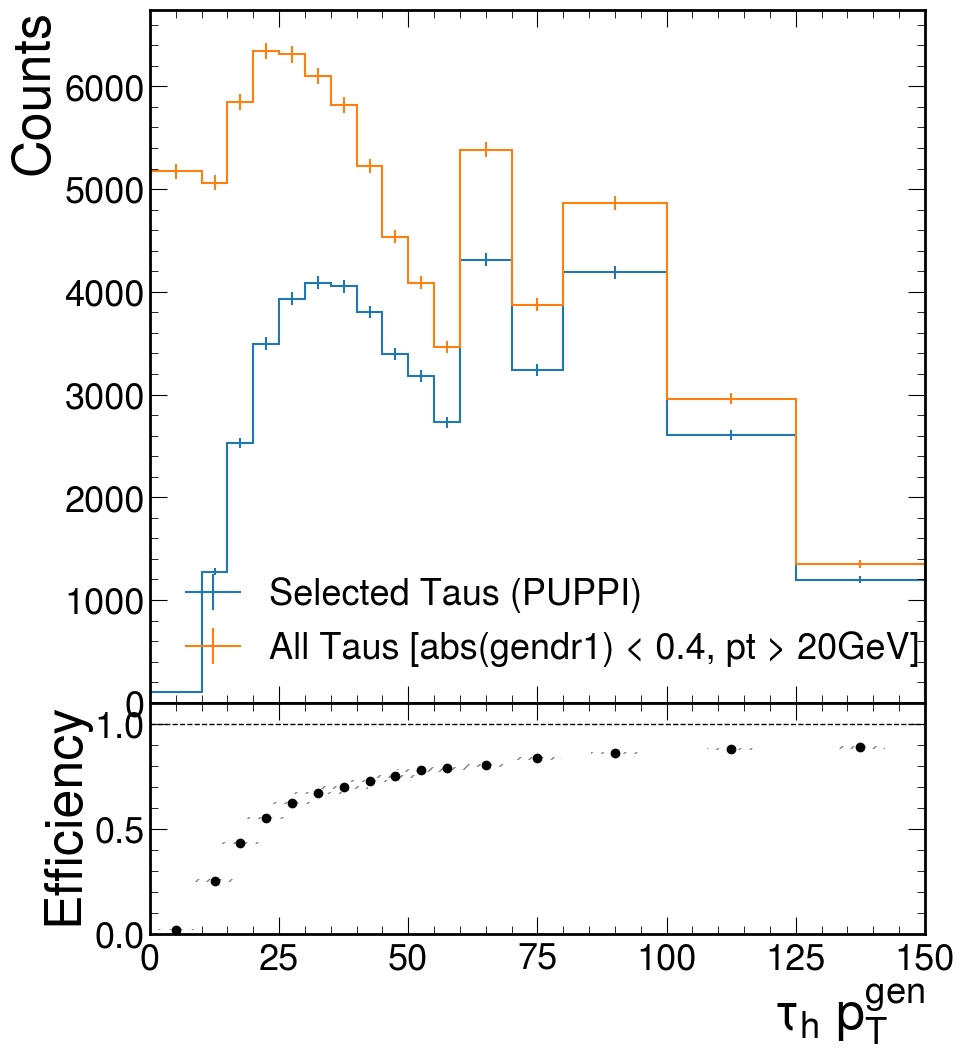

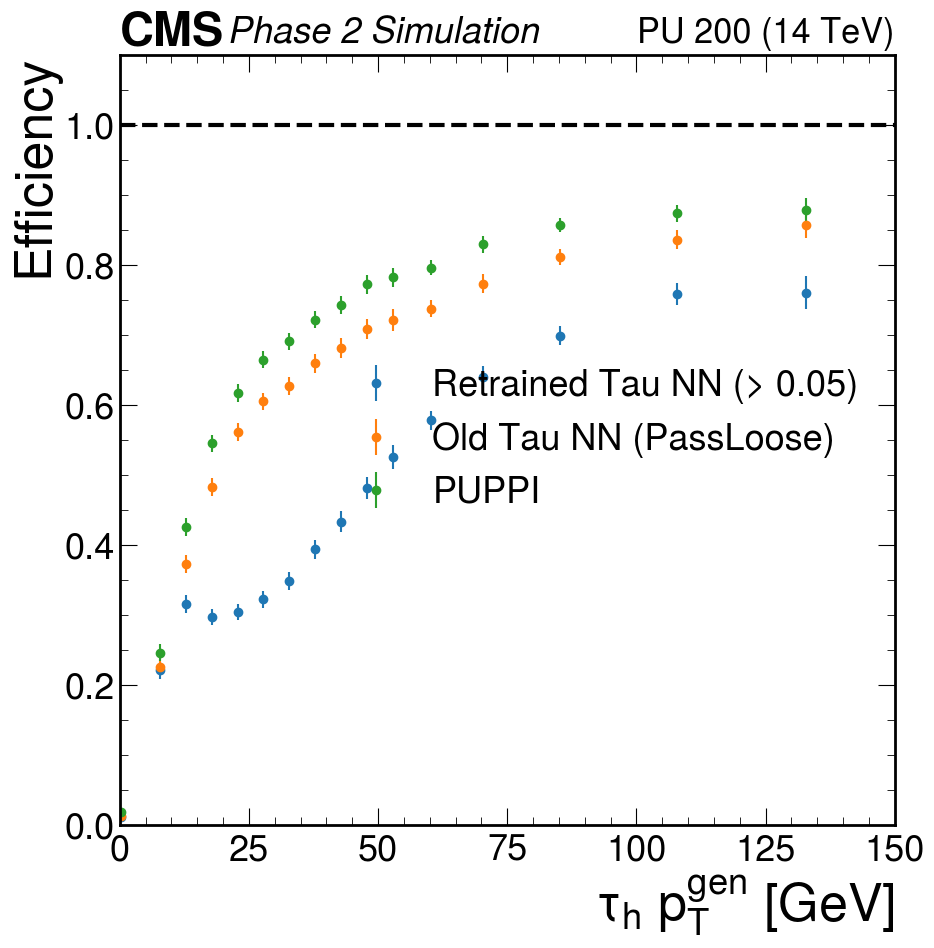

In [47]:
plot_pt_eff_puppi('../../models/Feb_4_2023_JetMetTalk_v2_pTShape_TruthPtRatio.h5', "../../ntuples/Jan_25_2023/test_sig_v11.root", cut_point = 0.92)